## **Model Overview**

In this project, we utilize Graph Neural Networks (GNNs) to predict energy consumption for households based on their features and relationships. Two models are trained as part of this analysis:

### **1. Base GNN Model**
- **Description**: 
  This model is trained on the original dataset without any augmentation. 
- **Purpose**: 
  Serves as a benchmark to evaluate the effectiveness of data augmentation.

### **2. GNN with Augmented Data**
- **Description**: 
  This model is trained on a dataset enriched with synthetic data generated through augmentation techniques.
- **Objective**: 
  By introducing controlled noise and variability to the original data, this approach aims to improve model generalization and performance.

### **Why Use GNNs?**
GNNs are particularly well-suited for this task because they can leverage the graph structure of the data:
- **Nodes**: Represent households, with their features encapsulating consumption patterns and other relevant variables.
- **Edges**: Represent relationships between households (e.g., based on similarity), encoded with weights.

By combining node features and edge information, GNNs learn to make predictions that consider both individual characteristics and relationships within the network. The addition of augmented data enhances the model's ability to generalize by exposing it to more diverse patterns and relationships.


In [1]:
import numpy as np
from gnn_models import *
import torch.optim as optim
import torch

In [2]:
node_file = './data/gnn/nodes.npz'
edge_file = './data/gnn/edges.npz'

# File paths
node_file_path = './data/gnn/nodes.npz'
edge_file_path = './data/gnn/edges.npz'

# Load data
node_data = np.load(node_file_path)
edge_data = np.load(edge_file_path)

# Extract node features and targets
node_features = torch.tensor(node_data['node_features'], dtype=torch.float32)  # Shape: (26, 58)
node_targets = torch.tensor(node_data['node_targets'], dtype=torch.float32)  # Shape: (26, 24)

# Extract edge index and edge weights
edge_index = torch.tensor(edge_data['edge_index'], dtype=torch.long)  # Shape: (2, 94)
edge_weights = torch.tensor(edge_data['edge_weights'], dtype=torch.float32)  # Shape: (94,)

print(f"Node features shape: {node_features.shape}")
print(f"Node targets shape: {node_targets.shape}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Edge weights shape: {edge_weights.shape}")


Node features shape: torch.Size([26, 58])
Node targets shape: torch.Size([26, 24])
Edge index shape: torch.Size([2, 94])
Edge weights shape: torch.Size([94])


### Training the model using node features and targets

In [3]:
import torch.optim as optim

# Define model
input_dim = node_features.shape[1]  # Number of node features
hidden_dim = 64  # Hidden layer size
output_dim = 24  # Predict next 24 time steps for grid
model = GNNModel(input_dim, hidden_dim, output_dim)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    # Zero out gradients
    optimizer.zero_grad()

    # Forward pass
    predictions = model(node_features, edge_index, edge_weights)  # Shape: (26, 24)

    # Compute loss
    loss = criterion(predictions, node_targets)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/100, Loss: 0.0936
Epoch 2/100, Loss: 0.0469
Epoch 3/100, Loss: 0.0266
Epoch 4/100, Loss: 0.0168
Epoch 5/100, Loss: 0.0063
Epoch 6/100, Loss: 0.0071
Epoch 7/100, Loss: 0.0093
Epoch 8/100, Loss: 0.0074
Epoch 9/100, Loss: 0.0096
Epoch 10/100, Loss: 0.0055
Epoch 11/100, Loss: 0.0051
Epoch 12/100, Loss: 0.0034
Epoch 13/100, Loss: 0.0040
Epoch 14/100, Loss: 0.0036
Epoch 15/100, Loss: 0.0033
Epoch 16/100, Loss: 0.0025
Epoch 17/100, Loss: 0.0032
Epoch 18/100, Loss: 0.0024
Epoch 19/100, Loss: 0.0028
Epoch 20/100, Loss: 0.0024
Epoch 21/100, Loss: 0.0022
Epoch 22/100, Loss: 0.0023
Epoch 23/100, Loss: 0.0024
Epoch 24/100, Loss: 0.0022
Epoch 25/100, Loss: 0.0022
Epoch 26/100, Loss: 0.0022
Epoch 27/100, Loss: 0.0022
Epoch 28/100, Loss: 0.0021
Epoch 29/100, Loss: 0.0022
Epoch 30/100, Loss: 0.0022
Epoch 31/100, Loss: 0.0023
Epoch 32/100, Loss: 0.0021
Epoch 33/100, Loss: 0.0023
Epoch 34/100, Loss: 0.0021
Epoch 35/100, Loss: 0.0021
Epoch 36/100, Loss: 0.0021
Epoch 37/100, Loss: 0.0022
Epoch 38/1

In [4]:
# Switch model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    predictions = model(node_features, edge_index, edge_weights)  # Shape: (26, 24)

# Calculate errors
errors = predictions - node_targets  # Shape: (26, 24)
abs_errors = torch.abs(errors)  # Absolute errors
mse_errors = errors ** 2  # Squared errors


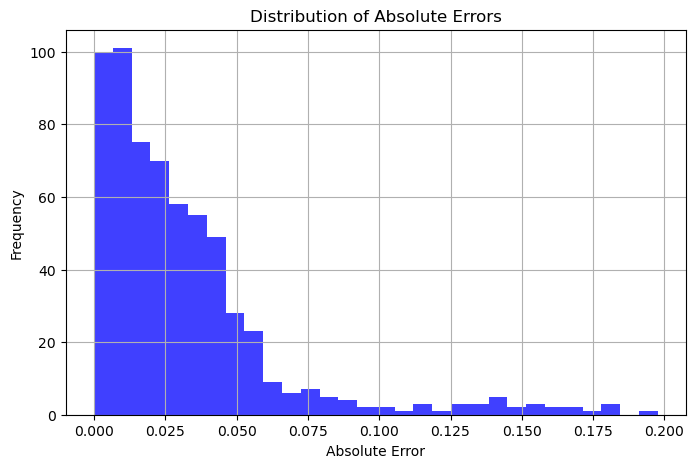

In [5]:
import matplotlib.pyplot as plt

# Flatten errors for plotting
flat_abs_errors = abs_errors.flatten().numpy()

# Plot distribution of errors
plt.figure(figsize=(8, 5))
plt.hist(flat_abs_errors, bins=30, alpha=0.75, color='blue')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


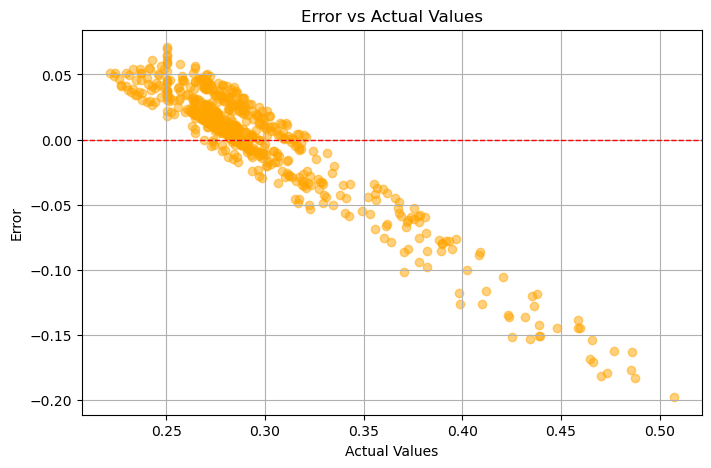

In [6]:
# Flatten actual values and errors
flat_actuals = node_targets.flatten().numpy()
flat_errors = errors.flatten().numpy()

# Plot scatter plot of errors vs actual values
plt.figure(figsize=(8, 5))
plt.scatter(flat_actuals, flat_errors, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Reference line
plt.title('Error vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Error')
plt.grid(True)
plt.show()


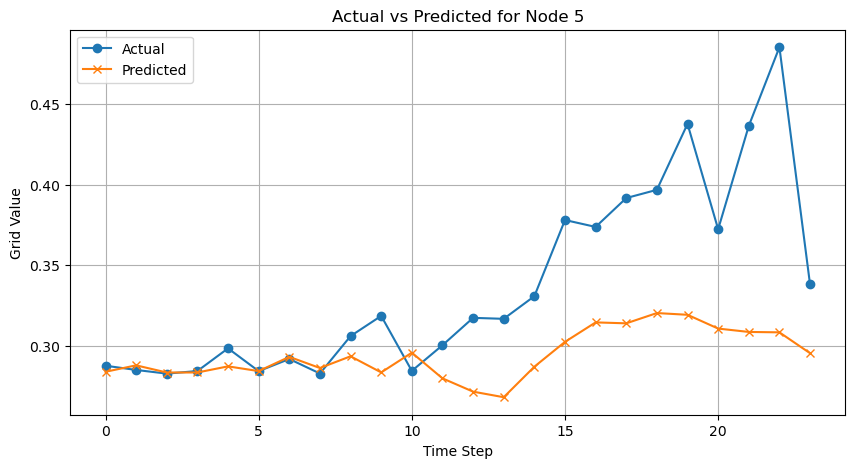

In [7]:
# Select a random node for analysis
node_index = 5  # You can change this to any index within range(0, 26)

# Extract actual and predicted values for this node
actual_values = node_targets[node_index].numpy()  # Shape: (24,)
predicted_values = predictions[node_index].numpy()  # Shape: (24,)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(range(24), actual_values, label='Actual', marker='o')
plt.plot(range(24), predicted_values, label='Predicted', marker='x')
plt.title(f'Actual vs Predicted for Node {node_index}')
plt.xlabel('Time Step')
plt.ylabel('Grid Value')
plt.legend()
plt.grid(True)
plt.show()


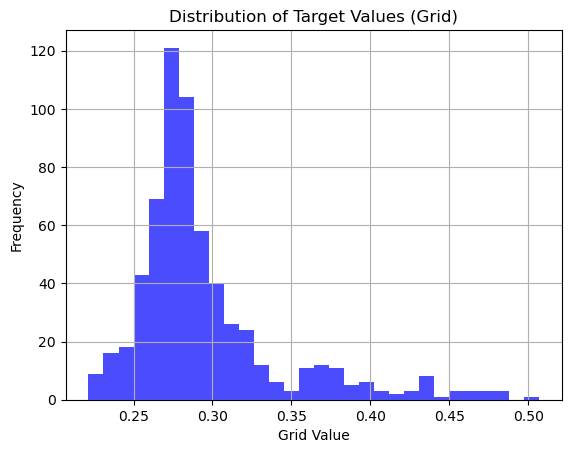

In [8]:
plt.hist(node_targets.flatten().numpy(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Target Values (Grid)')
plt.xlabel('Grid Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


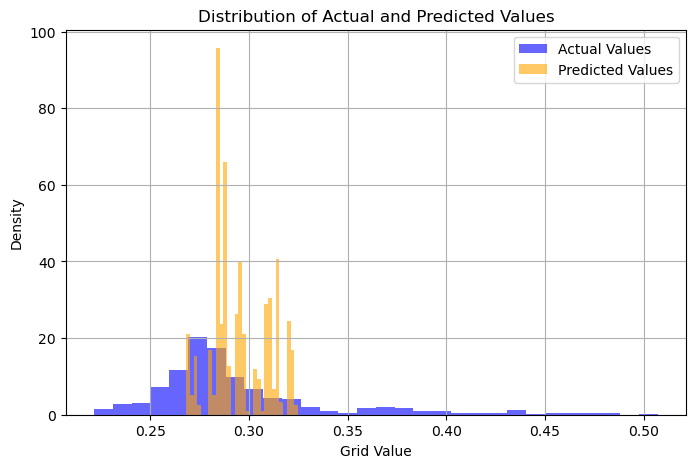

In [9]:
# Flatten actual and predicted values
flat_actuals = node_targets.flatten().numpy()
flat_predictions = predictions.flatten().detach().numpy()

# Plot the distribution
plt.figure(figsize=(8, 5))
# Histogram for actual values
plt.hist(flat_actuals, bins=30, alpha=0.6, color='blue', label='Actual Values', density=True)
# Histogram for predicted values as a line
plt.hist(flat_predictions, bins=30, alpha=0.6, color='orange', label='Predicted Values', density=True)  # Invisible histogram to get bins
#plt.plot(
#    np.histogram(flat_predictions, bins=30, density=True)[1][:-1],  # Bin centers
#    np.histogram(flat_predictions, bins=30, density=True)[0],  # Bin heights
#    linestyle='dotted', linewidth=2, color='orange', label='Predicted Values'
#)

# Add labels and title
plt.title('Distribution of Actual and Predicted Values')
plt.xlabel('Grid Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


### Augmentation: Problem-Specific Perspective
We noticed that the volume of data is very small, so we are trying to improve the model's performance by adding synthetic data generated through augmentation techniques, introducing controlled noise and variability to the existing features. The augmentation was performed by introducing variability to random subsets of node features (variables) while keeping the overall structure of the data intact.

#### Key Points of the Approach
    Node Subset Perturbation:
        For each synthetic data point, a subset of nodes (e.g., 10 out of 58) was selected randomly.
        This subset was perturbed by adding small Gaussian noise based on the distribution of the original features.
    
    Base Point Selection:
        A real data point was selected as the base for generating synthetic data, ensuring the augmented data remains realistic and grounded.
        
    Synthetic Targets:
        Targets were generated by adding controlled noise to the corresponding base target values, preserving their distribution while introducing slight variations.
    
    Rationale:
        This approach ensures diversity in the data, making the model more robust.
        By limiting perturbation to subsets, the augmented data closely resembles the original patterns while exploring variations.

In [10]:
# Generate synthetic data with random subsets of nodes
synthetic_node_features, synthetic_node_targets = generate_synthetic_data_with_node_subsets(
    node_features=node_features,
    node_targets=node_targets,
    num_synthetic_points=2000,  # Total synthetic points
    subset_size=26,  # Subset size (number of nodes per subset)
    noise_std=0.1  # Noise level
)

print(f"Original node features shape: {node_features.shape}")
print(f"Synthetic node features shape: {synthetic_node_features.shape}")
print(f"Original node targets shape: {node_targets.shape}")
print(f"Synthetic node targets shape: {synthetic_node_targets.shape}")


Original node features shape: torch.Size([26, 58])
Synthetic node features shape: (2000, 58)
Original node targets shape: torch.Size([26, 24])
Synthetic node targets shape: (2000, 24)


In [11]:
# Combine data
augmented_node_features, augmented_node_targets = combine_original_and_synthetic_data(
    node_features,
    node_targets,
    synthetic_node_features,
    synthetic_node_targets
)
print(f"Augmented node features shape: {augmented_node_features.shape}")
print(f"Augmented node targets shape: {augmented_node_targets.shape}")


Augmented node features shape: torch.Size([2026, 58])
Augmented node targets shape: torch.Size([2026, 24])


In [12]:
# Update edges
augmented_edge_index, augmented_edge_weights = update_edges_for_synthetic_nodes(augmented_node_features)
print(f"Augmented edge index shape: {augmented_edge_index.shape}")
print(f"Augmented edge weights shape: {augmented_edge_weights.shape}")


Augmented edge index shape: torch.Size([2, 1923991])
Augmented edge weights shape: torch.Size([1923991])


In [13]:
# Define model
input_dim = augmented_node_features.shape[1]
hidden_dim = 64
output_dim = node_targets.shape[1]  # Number of target variables
model = GNNModel(input_dim, hidden_dim, output_dim)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(augmented_node_features, augmented_edge_index, augmented_edge_weights)

    # Compute loss
    loss = criterion(predictions, augmented_node_targets)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/100, Loss: 0.0941
Epoch 2/100, Loss: 0.0851
Epoch 3/100, Loss: 0.0762
Epoch 4/100, Loss: 0.0684
Epoch 5/100, Loss: 0.0608
Epoch 6/100, Loss: 0.0536
Epoch 7/100, Loss: 0.0471
Epoch 8/100, Loss: 0.0406
Epoch 9/100, Loss: 0.0349
Epoch 10/100, Loss: 0.0301
Epoch 11/100, Loss: 0.0255
Epoch 12/100, Loss: 0.0228
Epoch 13/100, Loss: 0.0202
Epoch 14/100, Loss: 0.0185
Epoch 15/100, Loss: 0.0172
Epoch 16/100, Loss: 0.0156
Epoch 17/100, Loss: 0.0138
Epoch 18/100, Loss: 0.0122
Epoch 19/100, Loss: 0.0105
Epoch 20/100, Loss: 0.0093
Epoch 21/100, Loss: 0.0085
Epoch 22/100, Loss: 0.0079
Epoch 23/100, Loss: 0.0077
Epoch 24/100, Loss: 0.0079
Epoch 25/100, Loss: 0.0079
Epoch 26/100, Loss: 0.0080
Epoch 27/100, Loss: 0.0077
Epoch 28/100, Loss: 0.0081
Epoch 29/100, Loss: 0.0077
Epoch 30/100, Loss: 0.0073
Epoch 31/100, Loss: 0.0071
Epoch 32/100, Loss: 0.0069
Epoch 33/100, Loss: 0.0066
Epoch 34/100, Loss: 0.0063
Epoch 35/100, Loss: 0.0062
Epoch 36/100, Loss: 0.0062
Epoch 37/100, Loss: 0.0060
Epoch 38/1

In [14]:
model.eval()
with torch.no_grad():
    test_predictions = model(node_features, edge_index, edge_weights)
    test_loss = criterion(test_predictions, node_targets)
    print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.0148


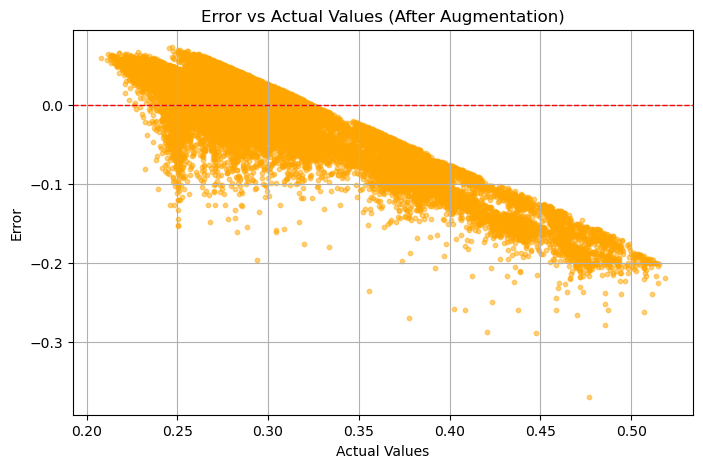

In [15]:
# Evaluate model on augmented data
model.eval()
with torch.no_grad():
    predictions_augmented = model(augmented_node_features, augmented_edge_index, augmented_edge_weights)

# Calculate errors
errors = predictions_augmented - augmented_node_targets

# Flatten actual values and errors
flat_actuals = augmented_node_targets.flatten().numpy()
flat_errors = errors.flatten().numpy()

# Plot scatter plot of errors vs. actual values
plt.figure(figsize=(8, 5))
plt.scatter(flat_actuals, flat_errors, alpha=0.5, color='orange', s=10)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Reference line
plt.title('Error vs Actual Values (After Augmentation)')
plt.xlabel('Actual Values')
plt.ylabel('Error')
plt.grid(True)
plt.show()


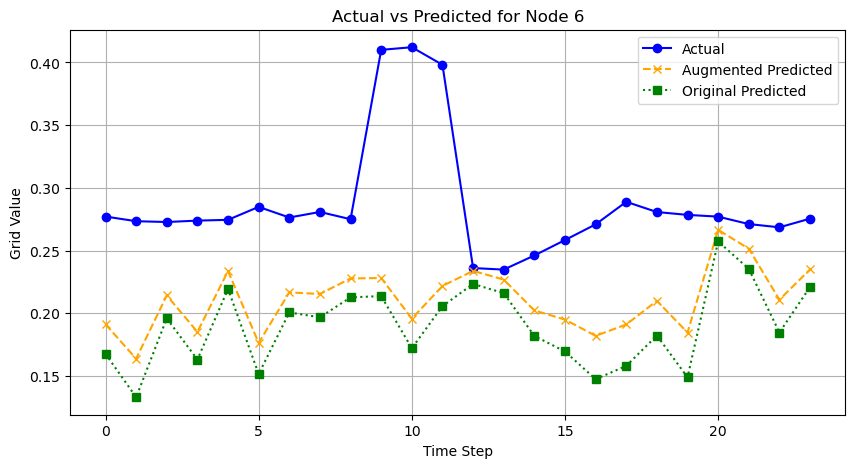

In [16]:
# Evaluate the original model on the original data
model.eval()
with torch.no_grad():
    original_predictions = model(node_features, edge_index, edge_weights)

# Select a random node for analysis
node_index = 6  # Change this to analyze a different node

# Extract actual and predicted values for this node (from augmented and original models)
actual_values = augmented_node_targets[node_index].numpy()  # Shape: (24,)
augmented_predicted_values = predictions_augmented[node_index].numpy()  # Shape: (24,)
original_predicted_values = original_predictions[node_index].numpy()  # Shape: (24,)

# Plot actual vs augmented predicted vs original predicted values
plt.figure(figsize=(10, 5))
plt.plot(range(24), actual_values, label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(range(24), augmented_predicted_values, label='Augmented Predicted', marker='x', linestyle='--', color='orange')
plt.plot(range(24), original_predicted_values, label='Original Predicted', marker='s', linestyle=':', color='green')
plt.title(f'Actual vs Predicted for Node {node_index}')
plt.xlabel('Time Step')
plt.ylabel('Grid Value')
plt.legend()
plt.grid(True)
plt.show()
